In [ ]:
!python --version

Python 3.10.12


# 0.セットアップ

In [1]:
!pip install qiskit
!pip install qiskit-algorithms
!pip install tqdm
!pip install gym


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

from scipy import linalg
from qiskit.circuit import Parameter
from qiskit_algorithms import TimeEvolutionProblem, VarQITE, NumPyMinimumEigensolver
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit.quantum_info import SparsePauliOp, Pauli, Statevector, state_fidelity
from qiskit.primitives import Estimator
from qiskit import *
from qiskit.visualization import plot_histogram

import tensorflow as tf
import copy
import tqdm
import random
from collections import deque, namedtuple
#from make_hamiltonian import *

2024-11-05 23:25:27.368652: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 23:25:27.369943: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 23:25:27.375111: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-05 23:25:27.390045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 23:25:27.412568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# 1.行動選択(ε-greedy)

In [2]:
class EpsGreedyQPolicy:
    def __init__(self, eps=1.0, eps_decay_rate=.95, min_eps=.1):
        self.eps = eps
        self.eps_decay_rate = eps_decay_rate
        self.min_eps = min_eps
    def select_action(self, q_values, is_training=True):
        assert q_values.ndim == 1 #assert:FalseでAssertionError
        nb_actions = q_values.shape[0]
        #
        if is_training:
            #探索
            if np.random.uniform() < self.eps:
                action = np.random.randint(0, nb_actions) #(nb_actions=len(action_space))
            #利用
            else:
                action = np.argmax(q_values)
        #利用
        else:
            action = np.argmax(q_values)

        return action
    #確率εの減衰
    def decay_eps_rate(self):
        self.eps = self.eps * self.eps_decay_rate
        if self.eps < self.min_eps:
            self.eps = self.min_eps


class RandomMemory:
    def __init__(self, limit):
        self.experiences = deque(maxlen=limit)

    def sample(self, batch_size):
        assert batch_size > 1, "batch_size must be positive integer"
        #学習用データをランダム抽出(経験再生)
        batch_size = min(batch_size, len(self.experiences))
        mini_batch = random.sample(self.experiences, batch_size)
        #Experience_Buffer?/batch:訓練データセットから取り出される一連のデータポイントのまとまり
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        terminal_batch = []
        #経験<s,a,s',r> + done:エピソード終了
        for state, action, reward, next_state, done in mini_batch:
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            terminal_batch.append(0. if done else 1.)

        state_batch = np.array(state_batch)
        action_batch = np.array(action_batch)
        reward_batch = np.array(reward_batch)
        next_state_batch = np.array(next_state_batch)
        terminal_batch = np.array(terminal_batch)

        assert len(state_batch) == batch_size

        return state_batch, action_batch, reward_batch, next_state_batch, terminal_batch
    #経験<s,a,s',r>をExperience Bufferに保存
    def append(self, state, action, reward, next_state, terminal=False):
        assert state is not None
        assert action is not None
        assert reward is not None
        assert next_state is not None
        assert terminal is not None

        self.experiences.append((state, action, reward, next_state, terminal))

# 2.エージェント(DQN)

In [25]:
class DQNAgent():
    """
        Deep Q Network Agent
    """

    def __init__(self,
                 training=True,
                 policy=None,
                 epochs=32,
                 gamma=.99, #減衰率
                 actions=None,
                 memory=None,
                 memory_interval=1,
                 model=None,
                 target_model=None,
                 update_interval=100,
                 train_interval=1,
                 batch_size=32,
                 warmup_steps=200,#ステップの上限?
                 observation=None,
                 loss_fn=None,
                 optimizer=None,
                 is_ddqn=False):

        self.training = training
        self.policy = policy
        self.actions = actions
        self.gamma = gamma
        self.observation = observation
        self.prev_observation = None
        self.memory = memory
        self.memory_interval = memory_interval
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.model = model
        self.target_model = target_model
        self.train_interval = train_interval
        self.update_interval = update_interval
        self.is_ddqn = is_ddqn
        self.epochs = epochs

        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.step = 0
    #Target Networkから出力されたQ値を元に行動選択
    def act(self,prev_act):
        q_values = self.target_model(np.array([self.observation]))
        q_values = tf.squeeze(q_values) #squeeze:サイズ1の次元を削除
        #直前行動のQ値低減
        if(prev_act >= 0):
            #q_valuesの値が直接変更できない
            q_values[prev_act] -= 3.0
        action_id = self.policy.select_action(q_values = test, is_training=self.training)
        self.recent_action_id = action_id
        action = self.actions[action_id]
        self.policy.decay_eps_rate()
        return action
    #行動したことによって変化した状態s'と報酬rの観測
    def observe(self, observation, reward=None, is_terminal=None):
        self.prev_observation = copy.deepcopy(self.observation)
        self.observation = observation

        if self.training and reward is not None:
            self.memory.append(self.prev_observation,
                               self.recent_action_id,
                               reward,
                               observation,
                               terminal=is_terminal)

        self.step += 1


    def train(self):
        for epoch in range(self.epochs):
            self._experience_replay()
    def update_target_hard(self):
        self.target_model.set_weights(self.model.get_weights())
    def update_target_soft(self, tau=0.001):
        target_model_weights = np.array(self.target_model.get_weights())
        model_weights = np.array(self.model.get_weights())
        new_weight = (1. - tau) * target_model_weights + tau * model_weights
        self.target_model.set_weights(new_weight)
    def _experience_replay(self):
        #経験の取り出し
        state0_batch, action_batch, reward_batch, state1_batch, terminal_batch  = self.memory.sample(self.batch_size)
        reward_batch = reward_batch.reshape(-1, 1)
        terminal_batch = terminal_batch.reshape(-1, 1)
        target_q_values = self.target_model(state1_batch)
        discounted_reward_batch = self.gamma * target_q_values * terminal_batch
        targets = reward_batch + discounted_reward_batch

        targets_one_hot = np.zeros((len(targets), len(self.actions)))
        if self.is_ddqn:
            q_values = self.model(state1_batch)
            argmax_actions = np.argmax(q_values, axis=1)
            for idx, (action, argmax_action) in enumerate(zip(action_batch, argmax_actions)):
                targets_one_hot[idx][action] = targets[idx][argmax_action]
        else:
            for idx, action in enumerate(action_batch):
                targets_one_hot[idx][action] = max(targets[idx])

        mask = tf.one_hot(action_batch, len(self.actions))
        state0_batch = tf.convert_to_tensor(state0_batch)

        self._train_on_batch(state0_batch, mask, targets_one_hot)

    @tf.function
    def _train_on_batch(self, states, masks, targets):
        with tf.GradientTape() as tape:
            y_preds = self.model(states)
            y_preds = tf.math.multiply(y_preds, masks)
            loss_value = self.loss_fn(targets, y_preds)

        grads = tape.gradient(loss_value, self.model.trainable_weights)

        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_weights))

    def reset(self):
        self.observation = None
        self.prev_observation = None

# 3.環境

In [26]:
import gym
from gym import spaces
class MyEnv(gym.Env):
  def __init__(self):
      super(MyEnv,self).__init__()
      #量子ビット数
      self.q_num = 4
      #SU2のreps=2(より1つだけ小さい/Hゲート含める)
      self.depth_limit = 11
      #ゲート数の上限(SU2:30)
      self.gate_limit = 30
      #行動：ゲートの追加(Rx,Rz,CNOT) * 量子ビット数 * 追加するゲート数(1個or1列) ※CNOTは一番下以外
      self.action_space = gym.spaces.Discrete(4 * self.q_num - 1)
      self.action_select = []
      #状態の範囲
      self.observation_space = gym.spaces.Discrete(self.q_num * self.depth_limit)
      ##maxcut問題用エッジ
      self.edge = [[0,1,1,1],[1,0,0,1],[1,0,0,1],[1,1,1,0]]
      #エネルギー期待値の閾値
      self.threshold = -1.9
      #リセット
      self.reset()

  def reset(self):
      #最初の回路S0(リスト)
      self.rl_state = np.array([[0] * self.depth_limit for i in range(self.q_num)])
      #書き込み用
      self.param = []
      #[制御ビット, 標的ビット, 列]
      self.rl_cx = []
      #期待値の閾値を満たした回数
      self.success_count = 0
      #ゲート数
      self.gate_count = 0
      return self.rl_state

  #リストから回路生成
  def create_Ansatz(self):
      #量子回路
      circuit = QuantumCircuit(self.q_num)
      #Hゲートで重ね合わせ
      for i in range(self.q_num):
        circuit.h(i)
      #Parameterのindex(回転ゲートの総数)
      index = 0
      for column in range(self.depth_limit):
        for qubit in range(self.q_num):
          #Parameterの定義
          theta = Parameter('θ[' + str(index) +']')
          #I
          if self.rl_state[qubit][column] == 0:
            #circuit.i(qubit)
            pass
          #rx
          elif self.rl_state[qubit][column] == 1:
            circuit.rx(theta, qubit)
            index += 1
          #ry
          elif self.rl_state[qubit][column] == 2:
            circuit.ry(theta, qubit)
            index += 1
          #rz
          elif self.rl_state[qubit][column] == 3:
            circuit.rz(theta, qubit)
            index += 1
          #cnot-control
          elif self.rl_state[qubit][column] == 4:
            target = 0
            for pair in self.rl_cx:
              if pair[0] == qubit and pair[2] == column:
                target = pair[1]
            circuit.cx(qubit,target)
          else:
            pass
      return circuit, index

  #maxcut問題
  def maxcut(self, graph):
    spin_list = []
    for i in range(len(graph)):
        for j in range(i+1, len(graph)):
            spin_string = ""
            for k in range(len(graph)):
                if k == i or k == j:
                    spin_string += "Z"
                else:
                    spin_string += "I"

            spin_num = graph[i][j]
            spin_list.append((spin_string, spin_num))
    return spin_list

  #1ステップ
  def step(self,action_index):
      #ハミルトニアン
      evolution_op = SparsePauliOp.from_list(self.maxcut(self.edge))
      #回路の更新
      self.update(action_index)
      self.gate_count += 1
      #Ansatzの生成
      ansatz, num_params = self.create_Ansatz()
      ansatz.draw()
      #回転角の初期化
      init_param_values = [np.pi/4 for i in range(num_params)]
      #init_param_values = np.zeros(num_params)
      
      #虚時間発展(初期状態から変化の有無を確認)
      test_time = 2.0
      test_timeslice = 10
      var_principle = ImaginaryMcLachlanPrinciple()
      evolution_problem = TimeEvolutionProblem(evolution_op, test_time, aux_operators=[evolution_op])
      var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator(), num_timesteps = test_timeslice)
      evolution_result = var_qite.evolve(evolution_problem)

      #期待値の変動があれば、虚時間発展を再開
      expectation_values = evolution_result.observables
      expectation = [item[0][0] for item in expectation_values]
      if(expectation[0] != expectation[-1]):
          time = 20
          timeslice = 100
          evolution_problem = TimeEvolutionProblem(evolution_op, time, aux_operators=[evolution_op])
          var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator(), num_timesteps = timeslice)
          evolution_result = var_qite.evolve(evolution_problem)
      #書き込み用パラメータ
      #self.param = np.reshape(-1,evolution_result.parameter_values[-1])
      
      #古典固有値計算
      eig_val, eig_vec = linalg.eigh(evolution_op.to_matrix())
      min_index = [k for k, x in enumerate(eig_val) if x == min(eig_val)]
      fidelity = []
      for param in evolution_result.parameter_values:
        state_step = Statevector(ansatz.assign_parameters(param))
        #fidelity計算
        sum_fidelity = 0
        for index in min_index:
          sum_fidelity += state_fidelity(state_step, eig_vec[:,index])
        fidelity.append(sum_fidelity)
      # 虚時間発展の結果から期待値を取得
      #times = evolution_result.times
      expectation_values = evolution_result.observables
      expectation = [item[0][0] for item in expectation_values]
      
      #深さ
      depth = ansatz.depth()
      #報酬(期待値&深さ)
      reward = 0
      #前のステップと同じ行動か
      #if(action_index == self.prev_act):
          #reward -= 3
      #エピソード終了か否か
      done = False   
      #深さかゲート数が上限到達
      if (depth >= self.depth_limit) or (self.gate_count >= self.gate_limit):
        reward -= 10
        done = True
      else:
        #期待値が閾値以下
        if expectation[-1] <= self.threshold:
          reward = (expectation[-1] + self.threshold)*(-2)
          self.threshold = expectation[-1] * 0.9
          done = True
        else:
          reward -= (expectation[-1] + (depth/self.depth_limit))
      self.prev_act = action_index
      return self.rl_state, action_index, reward, done, depth, fidelity[-1], expectation[-1] #, self.gate_count

  #ゲート追加
  def update(self,action_index):
      #qubit:0-3
      qubit = action_index % self.q_num
      #gate:1-4
      gate = (action_index // self.q_num) + 1
      #左詰めで数値を追加
      for c in reversed(range(len(self.rl_state[qubit]))):
        #CNOT
        if gate == 4:
          #標的ビット
          target = qubit + 1
          if self.rl_state[qubit][c] != 0 or self.rl_state[target][c] != 0:
            self.rl_state[qubit][c + 1] = gate
            self.rl_state[target][c + 1] = gate + 1
            self.rl_cx.append([qubit,target,c + 1])
            break
          else:
            if c == 0 :
              self.rl_state[qubit][c] = gate
              self.rl_state[target][c] = gate + 1
              self.rl_cx.append([qubit,target,c])
              break
        #Rx,Ry,Rz
        else:
          if self.rl_state[qubit][c] == 0:
            if c == 0 :
              self.rl_state[qubit][c] = gate
              break
          else:
            self.rl_state[qubit][c + 1] = gate
            break

  #ファイル書き込み
  def render(self,str):
      with open('result.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow([str])
          
  def write_ep(self,str) :
      with open('result.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([str])
      
  def write_result(self,depth,fidelity,expectation):
      with open('result.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerows(self.rl_state)
        writer.writerow([depth, np.round(fidelity, 5), np.round(expectation, 5)])
        writer.writerow([" "])

# 4.学習

In [27]:
##FutureWarningの非表示
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', DeprecationWarning)

#Qネットワークの生成
def build_q_network(input_shape, nb_output):
    #入力層:"input_shape"次元
    input_layer = tf.keras.layers.Input(shape=input_shape)
    #次元数："input_shape"->1
    x = tf.keras.layers.Flatten()(input_layer)
    #ニューロン32個の全結合層
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #出力層:アクション数 & 線形変換
    output_layer = tf.keras.layers.Dense(nb_output, activation='linear')(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

#自作環境の呼び出し
env = MyEnv()
#行動の総数
num_actions = env.action_space.n
#各行動を配列に格納
actions = np.arange(num_actions)
#ε-greedy法の初期値(ep間で初期化されず)
policy = EpsGreedyQPolicy(eps=1., eps_decay_rate=.99, min_eps=.1)
memory = RandomMemory(limit=50000)
#初期状態(回路:リスト)
ini_observation = env.reset()
loss_fn = tf.keras.losses.Huber()
optimizer = tf.keras.optimizers.Adam()

#2つのニューラルネットワークを生成
model = build_q_network(input_shape = ini_observation.shape, nb_output=len(actions))
target_model = build_q_network(input_shape = ini_observation.shape,nb_output=len(actions))
#エージェント
agent = DQNAgent(actions=actions,
                 memory=memory,
                 update_interval=200,
                 train_interval=1,
                 batch_size=32,
                 observation=ini_observation,
                 model=model,
                 target_model=target_model,
                 policy=policy,
                 loss_fn=loss_fn,
                 optimizer=optimizer,
                 is_ddqn=True)

#ステップ，報酬，深さ，期待値推移
step_history = []
reward_history = []
depth_history = []
fidelity_history = []
expectation_history = []
#各エピソードでの最終値
final_fidelity = []
final_expectation = []

#エピソード数
num_episodes = 100
#書き込み開始
env.render("---start{}---".format(num_episodes))
with tqdm.trange(num_episodes) as t:
    for episode in t:
        #エージェントのリセット
        #agent.reset()
        #環境のリセット&初期状態S0
        observation = env.reset()
        #初期状態S0の観測
        agent.observe(observation)
        done = False
        step = 0
        #1ステップ前の行動
        prev_act = -1
        #各エピソードでの報酬と深さ，フィデリティの推移
        episode_reward_history = []
        episode_depth_history = []
        episode_fidelity_history = []
        episode_expectation_history = []
        # train
        #書き込み
        env.write_ep("ep{}".format(episode))
        while not done:
            #行動
            action = agent.act(prev_act)
            #行動後の結果(状態,報酬,ep終了,深さ,フィデリティ,期待値)
            observation, prev_act, reward, done, depth, fidelity, expectation = env.step(action)
            #書き込み
            env.write_result(depth,fidelity,expectation)
            #ステップ加算
            step += 1
            #報酬，深さ,フィデリティ,期待値
            episode_reward_history.append(reward)
            episode_depth_history.append(depth)
            episode_fidelity_history.append(fidelity)
            episode_expectation_history.append(expectation)
            agent.observe(observation, reward, done)
            #エピソード終了
            if done:
                t.set_description('Episode {}: {} steps'.format(episode, step))
                t.set_postfix(episode_reward=np.sum(episode_reward_history))
                agent.train()
                if episode % 5 == 0:
                    agent.update_target_hard()
                #1エピソードでの推移
                step_history.append(step)
                depth_history.append(episode_depth_history)
                reward_history.append(episode_reward_history)
                fidelity_history.append(episode_fidelity_history)
                expectation_history.append(episode_expectation_history)
                #最終値
                final_fidelity.append(fidelity)
                final_expectation.append(expectation)
                step_0 = step
                

        #学習終了?
        agent.training = True


  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'ndim'

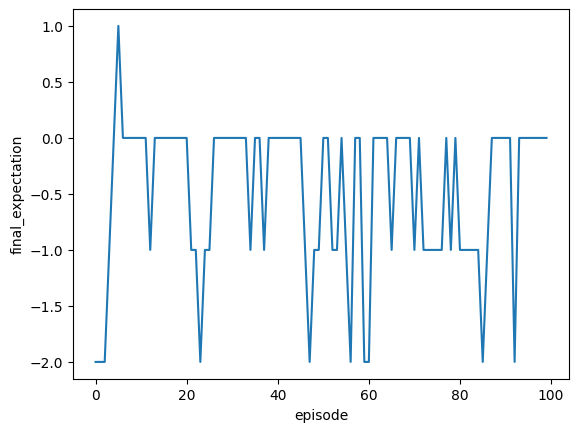

In [14]:
plt.ylabel('final_expectation')
plt.xlabel('episode')
plt.plot(final_expectation)
plt.show()

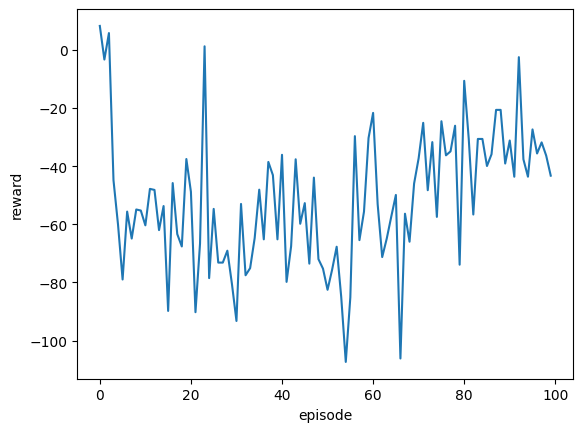

In [15]:
total_reward = []
for i in range(num_episodes):
  total_reward.append(np.sum(reward_history[i]))
plt.ylabel('reward')
plt.xlabel('episode')
plt.plot(total_reward)
plt.show()

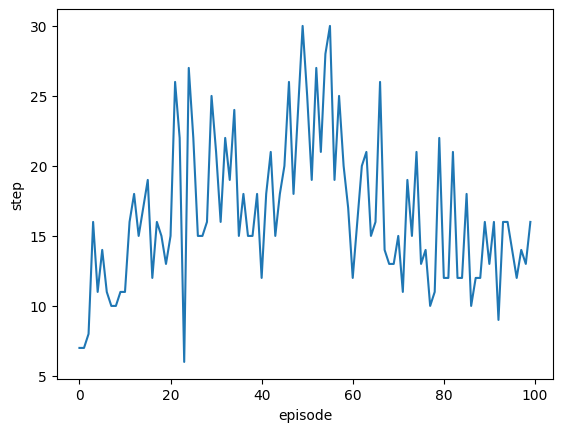

In [16]:
plt.ylabel('step')
plt.xlabel('episode')
plt.plot(step_history)
plt.show()